In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
    
eId = 'ensemble'
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')
t_full = np.load(os.path.join(path, str(eId), 't.npy'), mmap_mode='r')

mnorm = np.linalg.norm(m_full, axis=(1, 2))
mmin = np.min(mnorm)
mmax = mmin + 7 * mnorm.std()

vmin = 0
vmax = np.max(np.linalg.norm(v_full, axis=1))

## Compare 3D gradient methods

Building mesh gradient operators
Trying to load order 2 from file
Loaded
Trying to load order 1 from file
Loaded
Trying to load order 0 from file
Loaded
t = 5	Mean div(m): 0.000605	Mean strain rate: 0.00419
t = 5	Mean div(m): 0.000626	Mean strain rate: 0.00421
	Div(m) residual: 0.106 	Strain rate residual: 0.000463
t = 25	Mean div(m): 0.00111	Mean strain rate: 0.0444
t = 25	Mean div(m): 0.00114	Mean strain rate: 0.0446
	Div(m) residual: 0.0146 	Strain rate residual: 0.000403


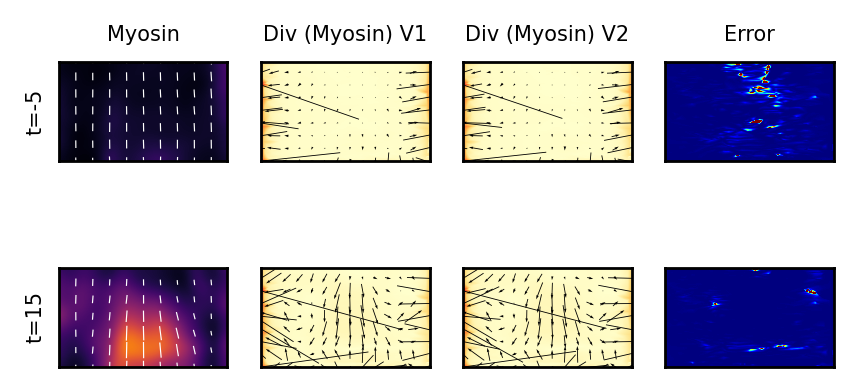

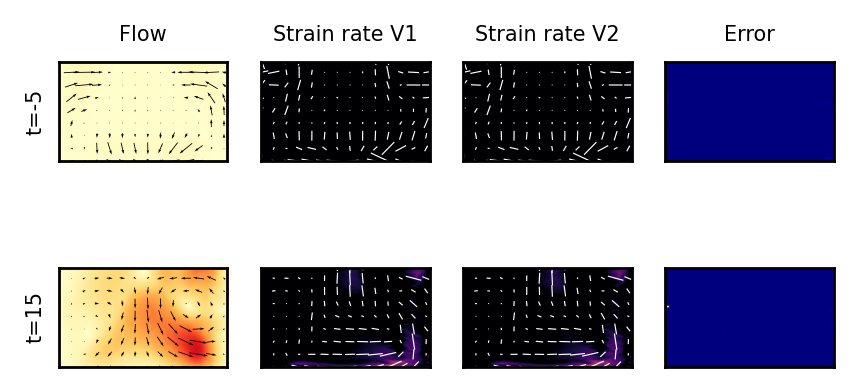

In [51]:
#Ask for a LOT of memory if you need to create these from scratch

from utils.plot_utils import *
from utils.geometry.fenics_utils import *
from utils.forecasting.transforms import EmbryoGradient, CovariantEmbryoGradient
from utils.geometry.geometry_utils import *

mesh_name='embryo_coarse_noll'

interp   = MeshInterpolator(mesh_name).fit(None)
tangent  = TangentSpaceTransformer(mesh_name).fit(None)
gradient0 = FenicsGradient_v0(mesh_name).fit(None, tangent=tangent)
#gradient1 = FenicsGradient_v1(mesh_name).fit(None, tangent=tangent)

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 6
fig1, ax1 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)
ax1[0, 0].set_title('Myosin')
ax1[0, 1].set_title('Div (Myosin) V1')
ax1[0, 2].set_title('Div (Myosin) V2')
ax1[0, 3].set_title('Error');

fig2, ax2 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)

ax2[0, 0].set_title('Flow')
ax2[0, 1].set_title('Strain rate V1')
ax2[0, 2].set_title('Strain rate V2')
ax2[0, 3].set_title('Error');

def gradients_3D(m, v, gradient):
    div_m = np.einsum('ij...j->i...', gradient.transform(m))
    d1_v = gradient.transform(v)
    E = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    if div_m.shape[0] == 3:
        div_m = tangent.inverse_transform(div_m)
        E = tangent.inverse_transform(E)
    
    div_m = interp.inverse_transform(div_m)
    E     = interp.inverse_transform(E)
    
    return div_m, E
        

for i, t in enumerate([5, 25]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]
    
    plot_tensor2D(ax1[i, 0], m0, vmin=mmin, vmax=mmax)
    color_2D(ax2[i, 0], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    plot_vector2D(ax2[i, 0], v0, skip=15)

    m0 = interp.transform(m0)
    v0 = interp.transform(v0)
    
    '''
    Gradient version 1
    '''
    div_m0, E0 = gradients_3D(m0, v0, gradient0)
    div_m1, E1 = gradients_3D(m0, v0, gradient1)
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m0, axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E0, axis=(0, 1))):.3g}')
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m1, axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E1, axis=(0, 1))):.3g}')
    
    print(f'\tDiv(m) residual: {mean_norm_residual(div_m0[None], div_m1[None]).mean():.3g}',
          f'\tStrain rate residual: {mean_norm_residual(E0[None], E1[None]).mean():.3g}')
    
    color_2D(ax1[i, 1], np.linalg.norm(div_m0, axis=0), cmap='YlOrRd')
    plot_vector2D(ax1[i, 1], div_m0, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 1], E0, vmin=mmin, vmax=mmax, skip=15)
    
    cmin, cmax= ax1[i, 1].get_images()[0].get_clim()

    color_2D(ax1[i, 2], np.linalg.norm(div_m1, axis=0), vmin=cmin, vmax=cmax, cmap='YlOrRd')
    plot_vector2D(ax1[i, 2], div_m1, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 2], E1, vmin=mmin, vmax=mmax, skip=15)
    
    color_2D(ax1[i, 3], mean_norm_residual(div_m0[None], div_m1[None]), vmin=0, vmax=1, cmap='jet')
    color_2D(ax2[i, 3], mean_norm_residual(E0[None], E1[None]), vmin=0, vmax=1, cmap='jet')


    ax1[i, 0].set_ylabel('t=%d' % tt)
    ax2[i, 0].set_ylabel('t=%d' % tt)

## Compute gradients in 2D

Building mesh gradient operators
Building order 2 from scratch
8357 vertices, N_in: (33428, 75213), N_out: (66856, 225639)
Loaded order 1 from file
Loaded order 0 from file
t = 5	Mean div(m): 0.000129	Mean strain rate: 0.00379
t = 5	Mean div(m): 0.000186	Mean strain rate: 0.00416
	Div(m) residual: 0.712 	Strain rate residual: 0.185
t = 25	Mean div(m): 0.000588	Mean strain rate: 0.0468
t = 25	Mean div(m): 0.00068	Mean strain rate: 0.0497
	Div(m) residual: 0.262 	Strain rate residual: 0.172


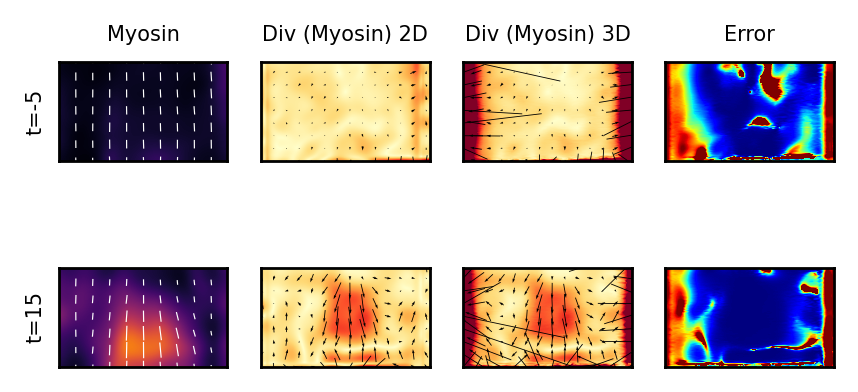

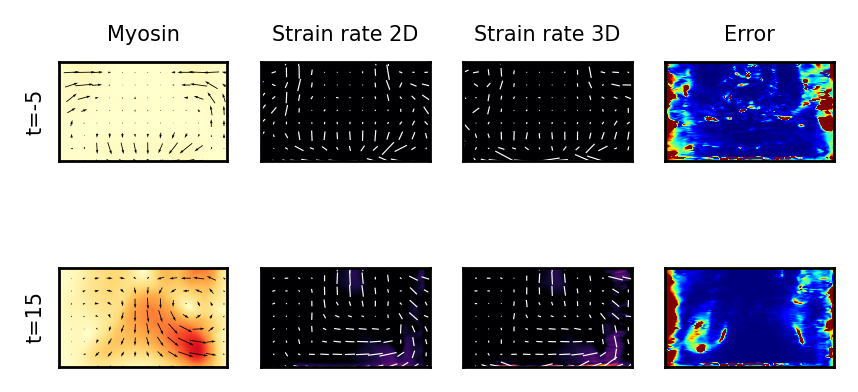

In [3]:
#Ask for a LOT of memory if you need to create these from scratch

from utils.plot_utils import *
from utils.geometry.fenics_utils import *
from utils.forecasting.transforms import EmbryoGradient, CovariantEmbryoGradient
from utils.geometry.geometry_utils import *

mesh_name='embryo_medium_noll'
gradient0 = CovariantEmbryoGradient().fit(v_full)
gradient1 = FenicsGradient(mesh_name).fit(None)
interp   = MeshInterpolator(mesh_name).fit(None)
tangent  = TangentSpaceTransformer(mesh_name).fit(None)
slc = np.s_[..., 20:-20]

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 6
fig1, ax1 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)
ax1[0, 0].set_title('Myosin')
ax1[0, 1].set_title('Div (Myosin) 2D')
ax1[0, 2].set_title('Div (Myosin) 3D')
ax1[0, 3].set_title('Error');

fig2, ax2 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)

ax2[0, 0].set_title('Myosin')
ax2[0, 1].set_title('Strain rate 2D')
ax2[0, 2].set_title('Strain rate 3D')
ax2[0, 3].set_title('Error');

for i, t in enumerate([5, 25]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]
    
    plot_tensor2D(ax1[i, 0], m0, vmin=mmin, vmax=mmax)
    color_2D(ax2[i, 0], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    plot_vector2D(ax2[i, 0], v0, skip=15)

    '''
    2D gradient
    '''
    div_m0 = np.einsum('ij...j->i...', gradient0.transform(m0))
    d1_v = gradient0.transform(v0)
    E0 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m0[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E0[slc], axis=(0, 1))):.3g}')
        
    color_2D(ax1[i, 1], np.linalg.norm(div_m0, axis=0), cmap='YlOrRd')
    plot_vector2D(ax1[i, 1], div_m0, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 1], E0, vmin=mmin, vmax=mmax, skip=15)
    
    cmin, cmax= ax1[i, 1].get_images()[0].get_clim()
    
    '''
    3D gradient on Embryo coarse
    '''
    m1 = interp.transform(m0)
    v1 = interp.transform(v0)
        
    div_m1 = np.einsum('ij...j->i...', gradient1.transform(m1))
    d1_v = gradient1.transform(v1)
    E1 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    if div_m1.shape[0] == 3:
        div_m1 = tangent.inverse_transform(div_m1)
        E1     = tangent.inverse_transform(E1)
        
    div_m1 = interp.inverse_transform(div_m1)
    E1     = interp.inverse_transform(E1)
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m1[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E1[slc], axis=(0, 1))):.3g}')

    color_2D(ax1[i, 2], np.linalg.norm(div_m1, axis=0), vmin=cmin, vmax=cmax, cmap='YlOrRd')
    plot_vector2D(ax1[i, 2], div_m1, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 2], E1, vmin=mmin, vmax=mmax, skip=15)
    
    color_2D(ax1[i, 3], mean_norm_residual(div_m0[None], div_m1[None]), vmin=0, vmax=1, cmap='jet')
    color_2D(ax2[i, 3], mean_norm_residual(E0[None], E1[None]), vmin=0, vmax=1, cmap='jet')
    
    print(f'\tDiv(m) residual: {mean_norm_residual(div_m0[None][slc], div_m1[None][slc]).mean():.3g}',
          f'\tStrain rate residual: {mean_norm_residual(E0[None][slc], E1[None][slc]).mean():.3g}')

    ax1[i, 0].set_ylabel('t=%d' % tt)
    ax2[i, 0].set_ylabel('t=%d' % tt)

t = 5	Mean div(m): 0.000129	Mean strain rate: 0.00379
t = 5	Mean div(m): 0.000181	Mean strain rate: 0.00392
	Div(m) residual: 0.657 	Strain rate residual: 0.192
t = 25	Mean div(m): 0.000588	Mean strain rate: 0.0468
t = 25	Mean div(m): 0.000651	Mean strain rate: 0.0477
	Div(m) residual: 0.305 	Strain rate residual: 0.182


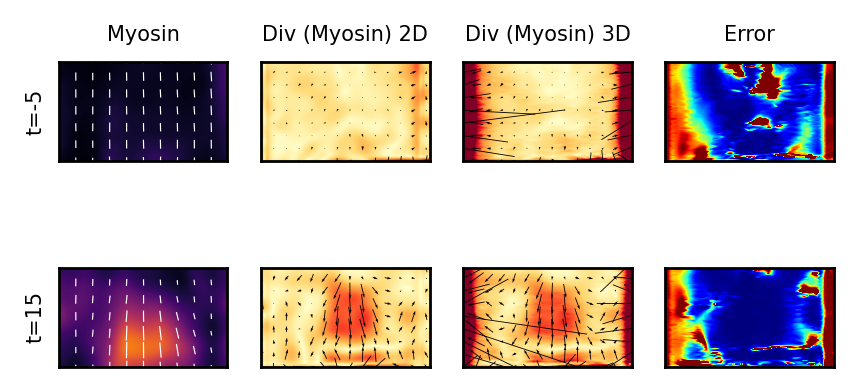

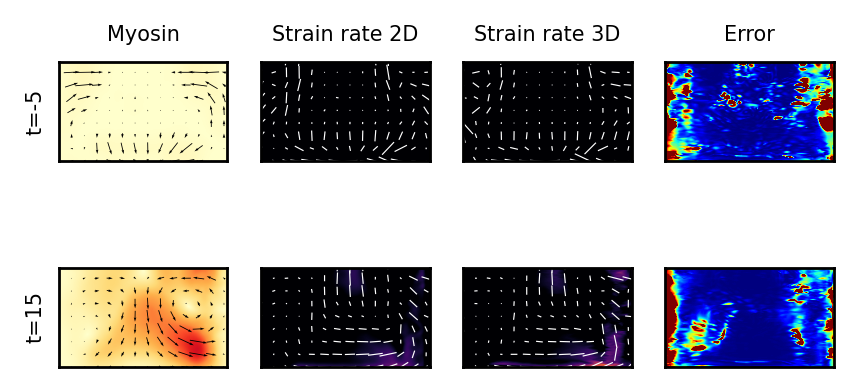

In [11]:
#Ask for a LOT of memory if you need to create these from scratch

from utils.plot_utils import *
from utils.geometry.fenics_utils import *
from utils.forecasting.transforms import EmbryoGradient, CovariantEmbryoGradient
from utils.geometry.geometry_utils import *

mesh_name='embryo_poles_noll'
gradient0 = CovariantEmbryoGradient().fit(v_full)
gradient1 = FenicsGradient(mesh_name).fit(None)
interp   = MeshInterpolator(mesh_name).fit(None)
tangent  = TangentSpaceTransformer(mesh_name).fit(None)
slc = np.s_[..., 20:-20]

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 6
fig1, ax1 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)
ax1[0, 0].set_title('Myosin')
ax1[0, 1].set_title('Div (Myosin) 2D')
ax1[0, 2].set_title('Div (Myosin) 3D')
ax1[0, 3].set_title('Error');

fig2, ax2 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)

ax2[0, 0].set_title('Myosin')
ax2[0, 1].set_title('Strain rate 2D')
ax2[0, 2].set_title('Strain rate 3D')
ax2[0, 3].set_title('Error');

for i, t in enumerate([5, 25]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]
    
    plot_tensor2D(ax1[i, 0], m0, vmin=mmin, vmax=mmax)
    color_2D(ax2[i, 0], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    plot_vector2D(ax2[i, 0], v0, skip=15)

    '''
    2D gradient
    '''
    div_m0 = np.einsum('ij...j->i...', gradient0.transform(m0))
    d1_v = gradient0.transform(v0)
    E0 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m0[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E0[slc], axis=(0, 1))):.3g}')
        
    color_2D(ax1[i, 1], np.linalg.norm(div_m0, axis=0), cmap='YlOrRd')
    plot_vector2D(ax1[i, 1], div_m0, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 1], E0, vmin=mmin, vmax=mmax, skip=15)
    
    cmin, cmax= ax1[i, 1].get_images()[0].get_clim()
    
    '''
    3D gradient on Embryo coarse
    '''
    m1 = interp.transform(m0)
    v1 = interp.transform(v0)
        
    div_m1 = np.einsum('ij...j->i...', gradient1.transform(m1))
    d1_v = gradient1.transform(v1)
    E1 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    if div_m1.shape[0] == 3:
        div_m1 = tangent.inverse_transform(div_m1)
        E1     = tangent.inverse_transform(E1)
        
    div_m1 = interp.inverse_transform(div_m1)
    E1     = interp.inverse_transform(E1)
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m1[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E1[slc], axis=(0, 1))):.3g}')

    color_2D(ax1[i, 2], np.linalg.norm(div_m1, axis=0), vmin=cmin, vmax=cmax, cmap='YlOrRd')
    plot_vector2D(ax1[i, 2], div_m1, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 2], E1, vmin=mmin, vmax=mmax, skip=15)
    
    color_2D(ax1[i, 3], mean_norm_residual(div_m0[None], div_m1[None]), vmin=0, vmax=1, cmap='jet')
    color_2D(ax2[i, 3], mean_norm_residual(E0[None], E1[None]), vmin=0, vmax=1, cmap='jet')
    
    print(f'\tDiv(m) residual: {mean_norm_residual(div_m0[None][slc], div_m1[None][slc]).mean():.3g}',
          f'\tStrain rate residual: {mean_norm_residual(E0[None][slc], E1[None][slc]).mean():.3g}')

    ax1[i, 0].set_ylabel('t=%d' % tt)
    ax2[i, 0].set_ylabel('t=%d' % tt)

Building mesh gradient operators
Loaded order 0 from file
Loaded order 1 from file
Loaded order 2 from file
t = 5	Mean div(m): 0.000129	Mean strain rate: 0.00379
t = 5	Mean div(m): 0.000192	Mean strain rate: 0.00388
	Div(m) residual: 0.976 	Strain rate residual: 0.202
t = 25	Mean div(m): 0.000588	Mean strain rate: 0.0468
t = 25	Mean div(m): 0.000659	Mean strain rate: 0.047
	Div(m) residual: 0.73 	Strain rate residual: 0.165


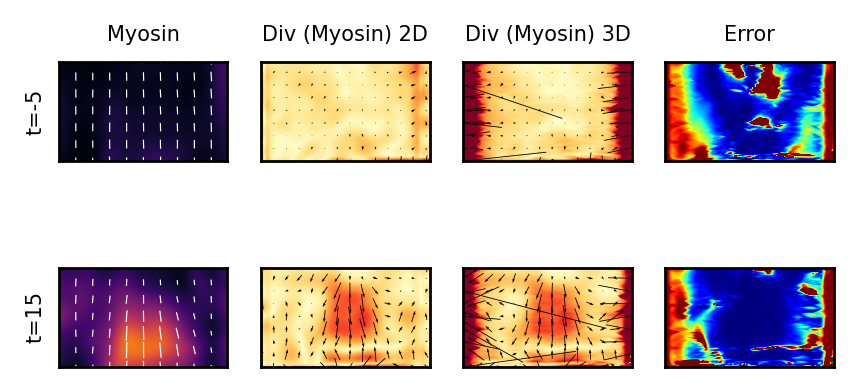

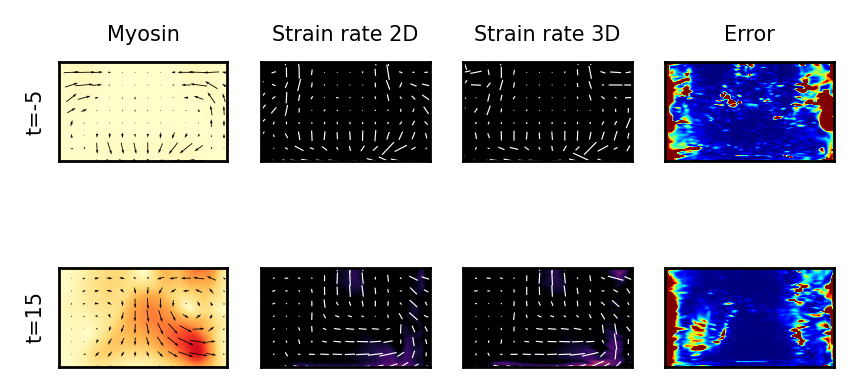

In [13]:
#Ask for a LOT of memory if you need to create these from scratch

from utils.plot_utils import *
from utils.geometry.fenics_utils import *
from utils.forecasting.transforms import EmbryoGradient, CovariantEmbryoGradient
from utils.geometry.geometry_utils import *

mesh_name='embryo_medium_noll'
mesh_name='embryo_coarse_noll'
gradient0 = CovariantEmbryoGradient().fit(v_full)
gradient1 = FenicsGradient(mesh_name).fit(None)
interp   = MeshInterpolator(mesh_name).fit(None)
tangent  = TangentSpaceTransformer(mesh_name).fit(None)
slc = np.s_[..., 20:-20]

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 6
fig1, ax1 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)
ax1[0, 0].set_title('Myosin')
ax1[0, 1].set_title('Div (Myosin) 2D')
ax1[0, 2].set_title('Div (Myosin) 3D')
ax1[0, 3].set_title('Error');

fig2, ax2 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)

ax2[0, 0].set_title('Myosin')
ax2[0, 1].set_title('Strain rate 2D')
ax2[0, 2].set_title('Strain rate 3D')
ax2[0, 3].set_title('Error');

for i, t in enumerate([5, 25]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]
    
    plot_tensor2D(ax1[i, 0], m0, vmin=mmin, vmax=mmax)
    color_2D(ax2[i, 0], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    plot_vector2D(ax2[i, 0], v0, skip=15)

    '''
    2D gradient
    '''
    div_m0 = np.einsum('ij...j->i...', gradient0.transform(m0))
    d1_v = gradient0.transform(v0)
    E0 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m0[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E0[slc], axis=(0, 1))):.3g}')
        
    color_2D(ax1[i, 1], np.linalg.norm(div_m0, axis=0), cmap='YlOrRd')
    plot_vector2D(ax1[i, 1], div_m0, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 1], E0, vmin=mmin, vmax=mmax, skip=15)
    
    cmin, cmax= ax1[i, 1].get_images()[0].get_clim()
    
    '''
    3D gradient on Embryo coarse
    '''
    m1 = interp.transform(m0)
    v1 = interp.transform(v0)
        
    div_m1 = np.einsum('ij...j->i...', gradient1.transform(m1))
    d1_v = gradient1.transform(v1)
    E1 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    if div_m1.shape[0] == 3:
        div_m1 = tangent.inverse_transform(div_m1)
        E1     = tangent.inverse_transform(E1)
        
    div_m1 = interp.inverse_transform(div_m1)
    E1     = interp.inverse_transform(E1)
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m1[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E1[slc], axis=(0, 1))):.3g}')

    color_2D(ax1[i, 2], np.linalg.norm(div_m1, axis=0), vmin=cmin, vmax=cmax, cmap='YlOrRd')
    plot_vector2D(ax1[i, 2], div_m1, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 2], E1, vmin=mmin, vmax=mmax, skip=15)
    
    color_2D(ax1[i, 3], mean_norm_residual(div_m0[None], div_m1[None]), vmin=0, vmax=1, cmap='jet')
    color_2D(ax2[i, 3], mean_norm_residual(E0[None], E1[None]), vmin=0, vmax=1, cmap='jet')
    
    print(f'\tDiv(m) residual: {mean_norm_residual(div_m0[None][slc], div_m1[None][slc]).mean():.3g}',
          f'\tStrain rate residual: {mean_norm_residual(E0[None][slc], E1[None][slc]).mean():.3g}')

    ax1[i, 0].set_ylabel('t=%d' % tt)
    ax2[i, 0].set_ylabel('t=%d' % tt)

In [6]:
from fenics import Mesh
mesh = Mesh('../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry/embryo_poles_noll.xml')
mesh

In [210]:
def csr_allclose(a, b, rtol=1e-5, atol = 1e-5):
    c = np.abs(np.abs(a - b) - rtol * np.abs(b))
    return c.max() <= atol

for e in tangent.e:
    enorm = np.linalg.norm(e, axis=1)
    print(enorm.min(), enorm.max())

for key in tangent.N:
    N = tangent.N[key]
    Ntra = N.T
    ide = sparse.identity(N.shape[0])
    
    NNT = N @ Ntra #Should be identity
    NTN = Ntra @ N #Equal to [e1[i]^2 + e2[i]^2, ...]
    
    print(key, N.shape, Ntra.shape, NNT.shape, NTN.shape)
    
    print(key, csr_allclose(NNT, sparse.identity(NNT.shape[0])), csr_allclose(sparse.identity(NTN.shape[0]), NTN))

0.9999999999999998 1.0000000000000002
0.9999999999999999 1.0
0 (1797, 1797) (1797, 1797) (1797, 1797) (1797, 1797)
0 True True
1 (3594, 5391) (5391, 3594) (3594, 3594) (5391, 5391)
1 True False
2 (7188, 16173) (16173, 7188) (7188, 7188) (16173, 16173)
2 True False


t = 5	Mean div(m): 0.000129	Mean strain rate: 0.00379
N N^T m_{ij} = m_{ij} True 	N N^T v = v True
N^T N N^T m_{ij} = N^T m_{ij} True 	N^T N N^T v = N^T v True
N^T N div(m) = div(m) True 	N^T N E_{ij} = E_{ij} False
N N^T div(m) = div(m) True 	N N^T E_{ij} = E_{ij} True
t = 5	Mean div(m): 0.000188	Mean strain rate: 0.00387
	Div(m) residual: 0.788	Strain rate residual: 0.46
t = 25	Mean div(m): 0.000588	Mean strain rate: 0.0468
N N^T m_{ij} = m_{ij} True 	N N^T v = v True
N^T N N^T m_{ij} = N^T m_{ij} True 	N^T N N^T v = N^T v True
N^T N div(m) = div(m) True 	N^T N E_{ij} = E_{ij} False
N N^T div(m) = div(m) True 	N N^T E_{ij} = E_{ij} True
t = 25	Mean div(m): 0.000651	Mean strain rate: 0.0469
	Div(m) residual: 0.526	Strain rate residual: 0.488


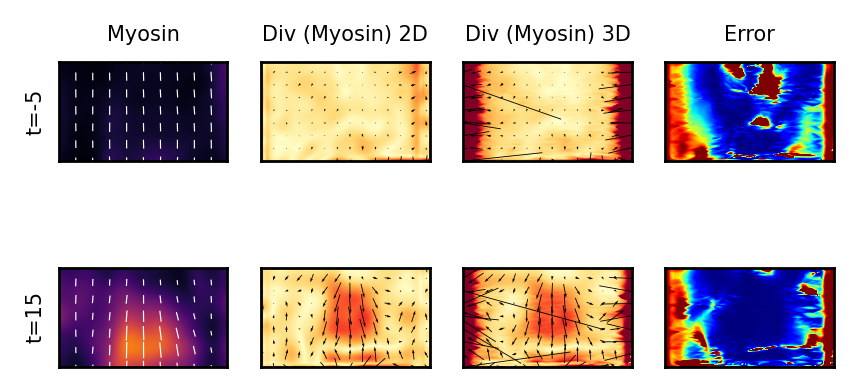

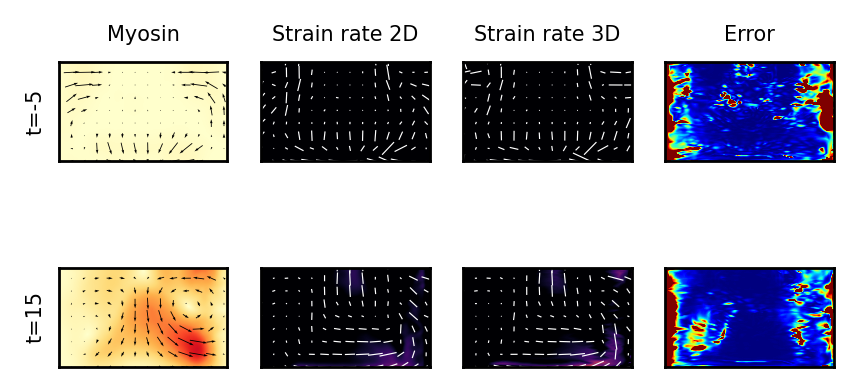

In [227]:
#Ask for a LOT of memory if you need to create these from scratch

from utils.plot_utils import *
from utils.geometry.fenics_utils import *
from utils.forecasting.transforms import EmbryoGradient, CovariantEmbryoGradient
from utils.geometry.geometry_utils import *

mesh_name='embryo_coarse_noll'
gradient0 = CovariantEmbryoGradient().fit(v_full)
#gradient1 = FenicsGradient_v0(mesh_name).fit(None)
interp   = MeshInterpolator(mesh_name).fit(None)
tangent  = TangentSpaceTransformer(mesh_name).fit(None)
slc = np.s_[..., 20:-20]

plt.rcParams['font.size'] = 6
plt.rcParams['axes.titlesize'] = 6
fig1, ax1 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)
ax1[0, 0].set_title('Myosin')
ax1[0, 1].set_title('Div (Myosin) 2D')
ax1[0, 2].set_title('Div (Myosin) 3D')
ax1[0, 3].set_title('Error');

fig2, ax2 = plt.subplots(2, 4, dpi=250, figsize=(4, 2), squeeze=False)

ax2[0, 0].set_title('Myosin')
ax2[0, 1].set_title('Strain rate 2D')
ax2[0, 2].set_title('Strain rate 3D')
ax2[0, 3].set_title('Error');

for i, t in enumerate([5, 25]):
    v0 = v_full[t]
    m0 = m_full[t]
    tt = t_full[t]
    
    plot_tensor2D(ax1[i, 0], m0, vmin=mmin, vmax=mmax)
    color_2D(ax2[i, 0], np.linalg.norm(v0, axis=0), vmin=vmin, vmax=vmax, cmap='YlOrRd')
    plot_vector2D(ax2[i, 0], v0, skip=15)

    '''
    2D gradient
    '''
    div_m0 = np.einsum('ij...j->i...', gradient0.transform(m0))
    d1_v = gradient0.transform(v0)
    E0 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m0[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E0[slc], axis=(0, 1))):.3g}')
        
    color_2D(ax1[i, 1], np.linalg.norm(div_m0, axis=0), cmap='YlOrRd')
    plot_vector2D(ax1[i, 1], div_m0, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 1], E0, vmin=mmin, vmax=mmax, skip=15)
    
    cmin, cmax= ax1[i, 1].get_images()[0].get_clim()
    
    '''
    3D gradient on Embryo coarse
    '''
    m1 = interp.transform(m0)
    v1 = interp.transform(v0)
    print('N N^T m_{ij} = m_{ij}', np.allclose(m1, tangent.inverse_transform(tangent.transform(m1))),
      '\tN N^T v = v', np.allclose(v1,     tangent.inverse_transform(tangent.transform(v1))))
          
    print('N^T N N^T m_{ij} = N^T m_{ij}', np.allclose(tangent.transform(m1), tangent.transform(tangent.inverse_transform(tangent.transform(m1)))),
          '\tN^T N N^T v = N^T v',         np.allclose(tangent.transform(v1), tangent.transform(tangent.inverse_transform(tangent.transform(v1)))))
        
    div_m1 = np.einsum('ij...j->i...', gradient1.transform(m1))
    d1_v = gradient1.transform(v1)
    E1 = 0.5 * (np.einsum('i...j->ij...', d1_v) + np.einsum('j...i->ij...', d1_v))
    
    if div_m1.shape[0] == 3:
        print('N^T N div(m) = div(m)', np.allclose(div_m1, tangent.transform(tangent.inverse_transform(div_m1))),
              '\tN^T N E_{ij} = E_{ij}', np.allclose(E1,     tangent.transform(tangent.inverse_transform(E1))))
        
        div_m1 = tangent.inverse_transform(div_m1)
        E1     = tangent.inverse_transform(E1)
        
    print('N N^T div(m) = div(m)', np.allclose(div_m1, tangent.inverse_transform(tangent.transform(div_m1))),
          '\tN N^T E_{ij} = E_{ij}', np.allclose(E1,     tangent.inverse_transform(tangent.transform(E1))))
        
    div_m1 = interp.inverse_transform(div_m1)
    E1     = interp.inverse_transform(E1)
    
    print(f't = {t}\tMean div(m): {np.mean(np.linalg.norm(div_m1[slc], axis=0)):.3g}\tMean strain rate: {np.mean(np.linalg.norm(E1[slc], axis=(0, 1))):.3g}')

    
    color_2D(ax1[i, 2], np.linalg.norm(div_m1, axis=0), vmin=cmin, vmax=cmax, cmap='YlOrRd')
    plot_vector2D(ax1[i, 2], div_m1, skip=15, scale=1e-2)
    plot_tensor2D(ax2[i, 2], E1, vmin=mmin, vmax=mmax, skip=15)
    
    color_2D(ax1[i, 3], mean_norm_residual(div_m0[None], div_m1[None]), vmin=0, vmax=1, cmap='jet')
    color_2D(ax2[i, 3], mean_norm_residual(E0[None], E1[None]), vmin=0, vmax=1, cmap='jet')
    
    print(f'\tDiv(m) residual: {mean_norm_residual(div_m0[None], div_m1[None]).mean():.3g}\tStrain rate residual: {mean_norm_residual(E0[None], E1[None]).mean():.3g}')

    ax1[i, 0].set_ylabel('t=%d' % tt)
    ax2[i, 0].set_ylabel('t=%d' % tt)